In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.optim import Adam
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor,self).__init__()
        vgg19_model=models.vgg19(pretrained=True)
        self.feature_layers=nn.Sequential(*list(vgg19_model.features.children())[:30])
        
    def forward(self,x,stop_layer):
        for index,layer in enumerate(self.feature_layers):
            x=layer(x)
            if index==stop_layer:
                break
        return x


In [2]:
# Define image preprocessing transformation
preprocess=transforms.Compose([
    transforms.Resize((400,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.2,0.2,0.2))
])

# Load and preprocess image
def load_image(image_path):
    image=Image.open(image_path).convert('RGB')
    image=preprocess(image).unsqueeze(0)
    return image

In [3]:

def tensor_to_image(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1, 2, 0)
    image=image * np.array((0.2,0.2,0.2)) + np.array((0.5,0.5,0.5))
    image=np.clip(image,0,1)
    return image

if __name__ == "__main__":
    
    style_image_path='/kaggle/input/dataset2/style image.jpg'
    content_image_path='/kaggle/input/image2/content image 2.jpg'

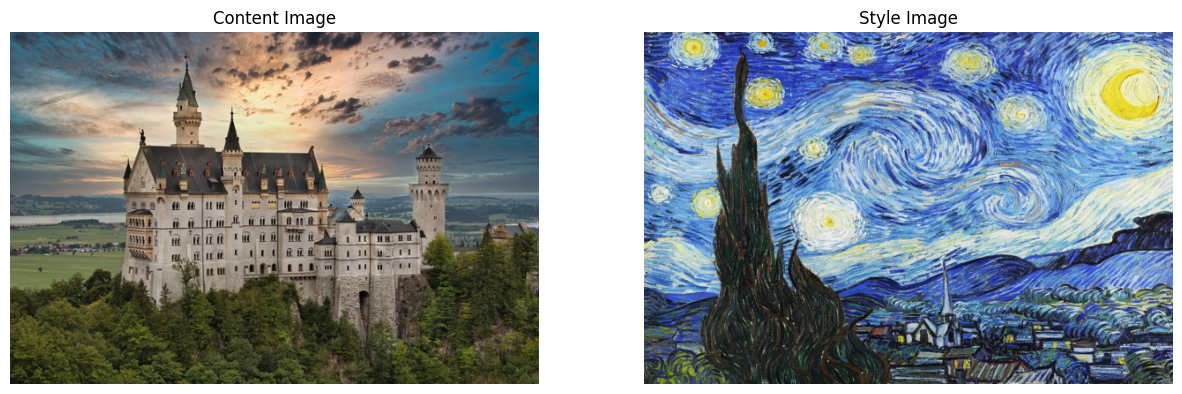

In [4]:
    
    style_img=load_image(style_image_path).to(device)
    content_img=load_image(content_image_path).to(device)
    generated_img=content_img.clone().requires_grad_(True).to(device)
    
    fig, axes=plt.subplots(1,2, figsize=(15, 5))
    axes[0].imshow(tensor_to_image(content_img))
    axes[0].set_title('Content Image')
    axes[0].axis('off')
    
    axes[1].imshow(tensor_to_image(style_img))
    axes[1].set_title('Style Image')
    axes[1].axis('off')
    plt.show()

In [5]:
    optimizer=Adam([generated_img], lr=0.003)
    feature_extractor=FeatureExtractor().to(device)
    
    def gram_matrix(feature_map, channels, height, width):
        features=feature_map.view(channels, height * width)
        gram=torch.mm(features, features.t())
        return gram

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 146MB/s]  


In [6]:
    content_weight=1.0
    style_weight=0.01
    num_epochs=4000

Epoch [1000/4000], Loss: 123792864.0000


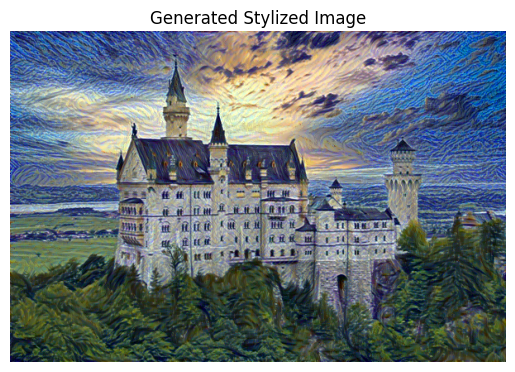

Epoch [2000/4000], Loss: 34391120.0000


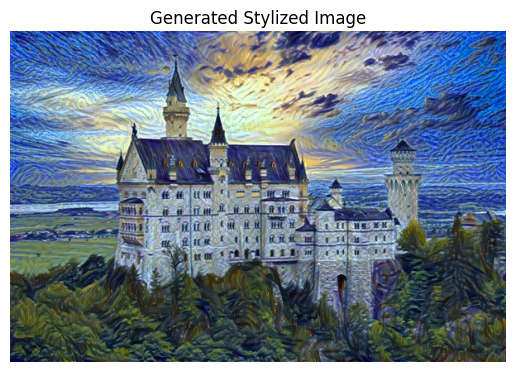

Epoch [3000/4000], Loss: 12859397.0000


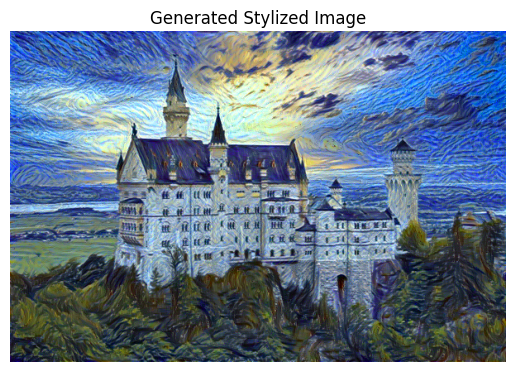

Epoch [4000/4000], Loss: 5866996.0000


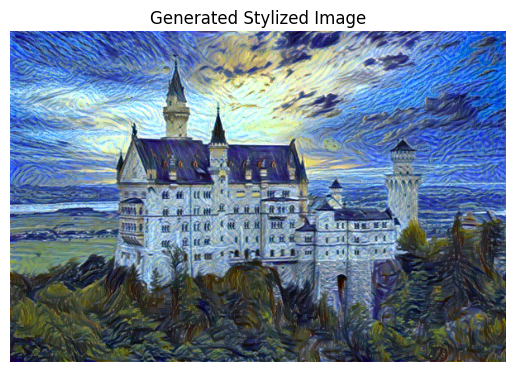

In [7]:
    for epoch in range(num_epochs):
        content_loss=style_loss = 0.0
        generated_features=feature_extractor(generated_img, 21)
        content_features=feature_extractor(content_img, 21)
        content_loss=torch.mean((generated_features - content_features) ** 2)
        
        style_layer_indices= [0, 5, 10, 19, 28]
        style_layer_weights= [2.0, 1.5, 1.0, 0.5, 0.25]
        for idx, layer_idx in enumerate(style_layer_indices):
            generated_layer_feats=feature_extractor(generated_img, layer_idx)
            style_layer_feats=feature_extractor(style_img, layer_idx)
            
            g_channels, g_height, g_width =generated_layer_feats.shape[1:]
            s_channels, s_height, s_width =style_layer_feats.shape[1:]
            
            gram_generated=gram_matrix(generated_layer_feats, g_channels, g_height, g_width)
            gram_style=gram_matrix(style_layer_feats, s_channels, s_height, s_width)
            
            layer_style_loss=torch.mean((gram_generated - gram_style) ** 2)
            style_loss+=style_layer_weights[idx] * layer_style_loss
        
        total_loss = content_weight*content_loss+style_weight*style_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')
            plt.imshow(tensor_to_image(generated_img))
            plt.title('Generated Stylized Image')
            plt.axis('off')
            plt.show()